# Modules

In [1]:
%load_ext autoreload
%autoreload 2w

In [2]:
import sys
import gc

import urllib.request
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import matplotlib
import seaborn as sns
import cv2

import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, ASGD, SGD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sys.path.append('..')
from src import config, dataset, models, utils

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['ggplot', 'bmh'])
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

display_settings = {
    'max_columns': 999,
    'expand_frame_repr': True,
    'max_rows': 999,
    'precision': 4,
    'show_dimensions': True
}

for op, value in display_settings.items():
    pd.set_option("display.{}".format(op), value)


%matplotlib inline

In [3]:
def fix_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
fix_seeds()

# Data

In [4]:
label_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

df_train = pd.read_csv(config.METADATA_TRAIN)
df_test = pd.read_csv(config.METADATA_TEST)

# artificially augment the dataset by duplicating images. Randomized transforms are applied to each one to make then unique to the model
df_train = dataset.oversample(df_train, label_cols, factor=4, balance_classes=True)

# split between training and validation set to monitor model overfitting
df_train, df_val = dataset.stratified_split(df_train, label_cols, test_size=.16)

ds_train = dataset.PlantPathology(df_train, label_cols=label_cols, is_test=False)
ds_val = dataset.PlantPathology(df_val, label_cols=label_cols, is_test=False)
ds_test = dataset.PlantPathology(df_test, is_test=True)

print(f'Number of images in training set: {len(ds_train)}')
print(f'Number of images in valiadtion set: {len(ds_val)}')
print(f'Number of images in test set: {len(ds_test)}')

Number of images in training set: 9482
Number of images in valiadtion set: 1807
Number of images in test set: 1821


## Target distribution

Images are partitioned into 4 distinct classes:
* leaves showing rust symptoms characterized by reddish circular spots. It's the most common occurrence in the dataset with 34% of the samples,
* leaves with scab disease characterized by brown spots and deformed leaves. It's the second most common class in the dataset where it appears on 33% of the samples,
* healthy leaves with no sign of a disease, accounting for 28% of the samples in the dataset,
* leaves with multiple diseases. This class is particular because it occurs when leaves show two or more diseases and as such can be viewed as a mixture of the rust and scab classes. However, such occurrences seem anecdotal as they represent around 5% of the samples. 

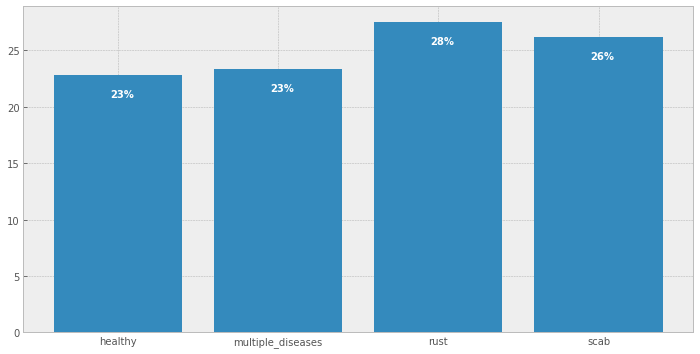

In [5]:
n_classes = len(ds_train.label_cols)
fig, ax = plt.subplots(figsize=(12, 6))

heights = [100 * ds_train.df_metadata[c].sum() / len(ds_train) for c in ds_train.label_cols]
ax.bar(x=ds_train.label_cols, height=heights)

for i, v in enumerate(heights):
    ax.text(i - .05, v - 2, f'{v:.0f}%', color='white', fontweight='bold')

## Training set images

Some observations:
* images don't have unit aspect ratio. They are of resolution 1365 x 2018 --> might reduce the resolution to speedup training,
* images have 3 channels (RGB), --> 3d grouped convolutions,
* leaves are almost always centered on images --> easier cropping,
* images often contain several leaves, either of the same tree or of different trees,
* images depth of field is low so that only the front leave is clear and the background is very blurry. However it happens that parts of the main leave is out of focus. --> Segmentation step to isolate main leave will likely improve model's performance,
* images are taken in nature, so lightning across images is different (direction, luminosity, color of the light source, direct or indirect lightning, reflections, shadows) --> might need histogram normalization

The images shown bellow are a comparison between the original samples and their transformed counterpart.

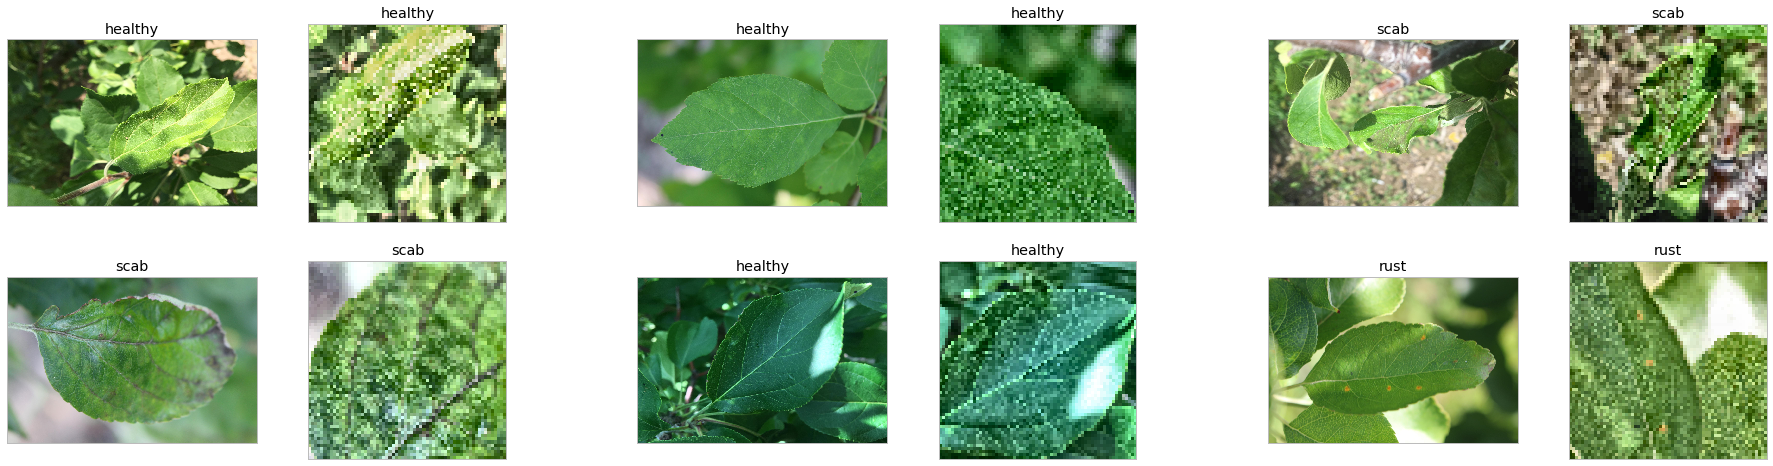

In [6]:
fig = utils.plot_samples(ds_train)

## Test set images

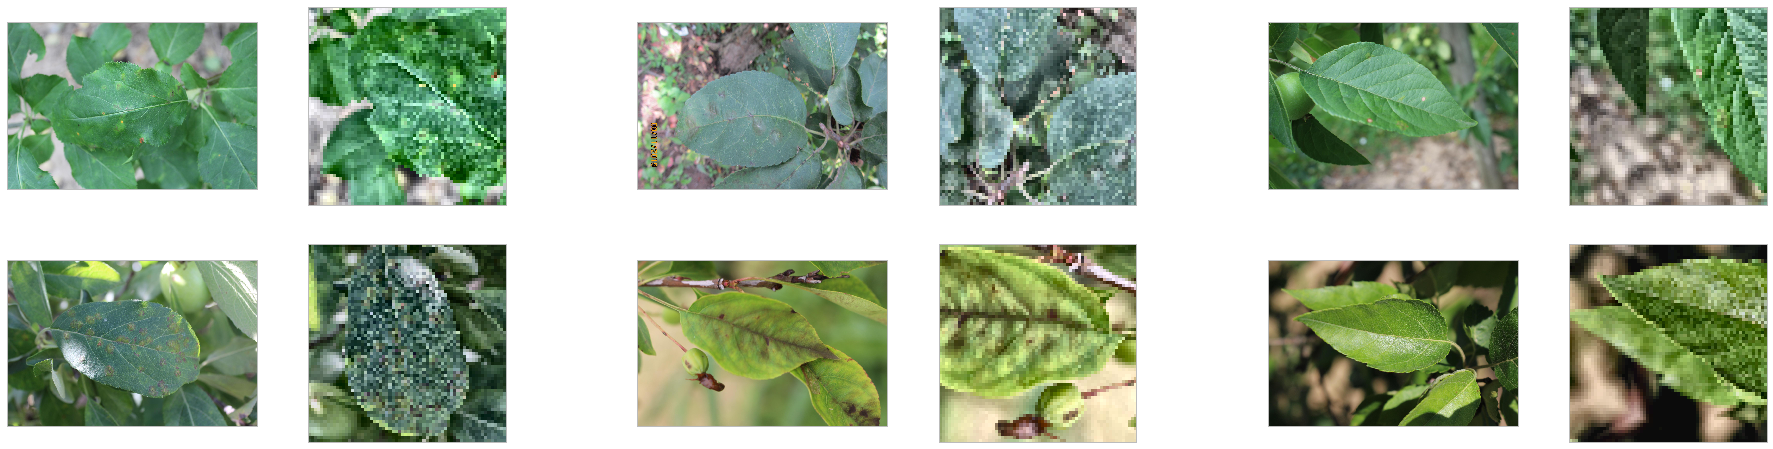

In [7]:
fig = utils.plot_samples(ds_test)

# Model

## Training

In [8]:
load_model = False
model_name = 'best'

# hyperparameters
batch_size = 64
n_epochs = 100
learning_rate = 1e-3
min_epoch, patience = 10, 10
verbose = 1

# data loaders
n_classes = len(ds_train.label_cols)
dl_train = DataLoader(ds_train, batch_size, num_workers=0)
dl_val = DataLoader(ds_val, batch_size, num_workers=0)
dl_test = DataLoader(ds_test, batch_size, num_workers=0)
#class_weigths = torch.tensor(ds_train.label_weights, device=device)

# model
model = models.WideResNet(in_channels=3, first_out_channels=8, n_classes=n_classes, k=1, n=3, n_stages=3)
#model.apply(models.weight_init)
criterion = CrossEntropyLoss(reduction='sum')
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

if load_model:
    checkpoint = torch.load(config.get_model_filename(model_name))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    restart_epoch = checkpoint['epoch']
else:
    restart_epoch = 1
    
loss_history, eval_loss_history, eval_roc_auc_history = models.train(model, criterion, optimizer, dl_train, dl_val, n_epochs, restart_epoch, model_name, min_epoch, patience)

Epoch:   1 - Train loss: 1.3422 | Eval loss: 1.3762 - Eval ROC-AUC: 0.6170
Epoch:   2 - Train loss: 1.3182 | Eval loss: 1.3423 - Eval ROC-AUC: 0.6346
Epoch:   3 - Train loss: 1.3020 | Eval loss: 1.3334 - Eval ROC-AUC: 0.6481
Epoch:   4 - Train loss: 1.2943 | Eval loss: 1.3303 - Eval ROC-AUC: 0.6550
Epoch:   5 - Train loss: 1.2806 | Eval loss: 1.3020 - Eval ROC-AUC: 0.6727
Epoch:   6 - Train loss: 1.2715 | Eval loss: 1.3078 - Eval ROC-AUC: 0.6754
Epoch:   7 - Train loss: 1.2613 | Eval loss: 1.3287 - Eval ROC-AUC: 0.6747
Epoch:   8 - Train loss: 1.2482 | Eval loss: 1.2590 - Eval ROC-AUC: 0.6944
Epoch:   9 - Train loss: 1.2446 | Eval loss: 1.2869 - Eval ROC-AUC: 0.6982
Epoch:  10 - Train loss: 1.2364 | Eval loss: 1.3266 - Eval ROC-AUC: 0.6868
Epoch:  11 - Train loss: 1.2305 | Eval loss: 1.2825 - Eval ROC-AUC: 0.7014
Epoch:  12 - Train loss: 1.2202 | Eval loss: 1.4918 - Eval ROC-AUC: 0.6903
Epoch:  13 - Train loss: 1.2119 | Eval loss: 1.2634 - Eval ROC-AUC: 0.7289
Epoch:  14 - Train loss: 

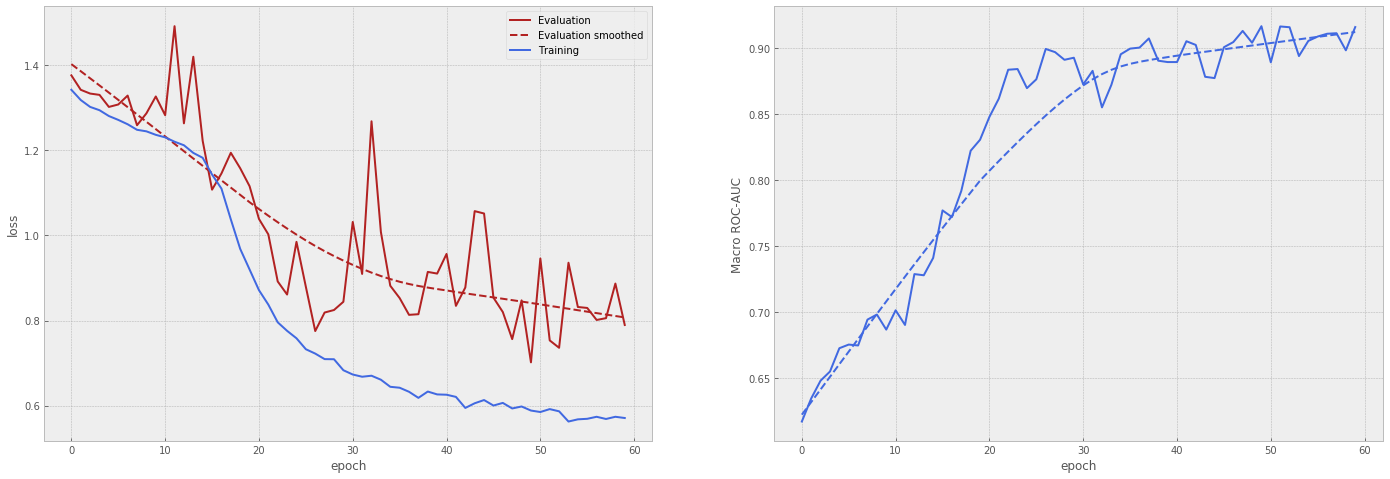

In [9]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

# plot loss history
fig, (ax_loss, ax_auc) = plt.subplots(ncols=2, figsize=(24, 8))

x = [i for i in range(len(eval_loss_history))]

ax_loss.plot(x, eval_loss_history, label='Evaluation', c='firebrick')
ax_loss.plot(x, lowess(eval_loss_history, x, return_sorted=False), label='Evaluation smoothed', c='firebrick', ls='--')
ax_loss.plot(x, loss_history, label='Training', c='royalblue')
ax_loss.set_xlabel('epoch')
ax_loss.set_ylabel('loss')
ax_loss.legend()

ax_auc.plot(x, eval_roc_auc_history, c='royalblue')
ax_auc.plot(x, lowess(eval_roc_auc_history, x, return_sorted=False), label='ROC-AUC smoothed', c='royalblue', ls='--')
ax_auc.set_xlabel('epoch')
ax_auc.set_ylabel('Macro ROC-AUC')

plt.show()

By plotting the loss history, it is clear that the difference between training and evaluation loss doesn't converge but stays rather constant after epoch 30. This is a sign that the model have a hard time generalizing to validation sample. However, both loss show a decreasing trend, indicating that the model is still learning. This is confirmed by the ROC-AUC curve on the right, which has not plateaued yet on the 60th epoch. Decreasing the learning rate and continuing the training for some more epochs should help reach a better performance.

Nevertheless, the main issue here is overfitting early on even though the model has dropout (dropout2d, which drops entire features maps) layers and the loss function has a L2 regularization term. The model is rather shallow with around 100k learnable parameters, so the most efficient solution here would be to implement a better oversampling strategy, or to gather more data (~2000 training sample is small).

## Analysis of validation results

In [10]:
# load best model's weights
checkpoint = torch.load(config.get_model_filename(model_name))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

_, _, y_val_hat_running, y_val_running = models.evaluate(model, criterion, optimizer, dl_val)

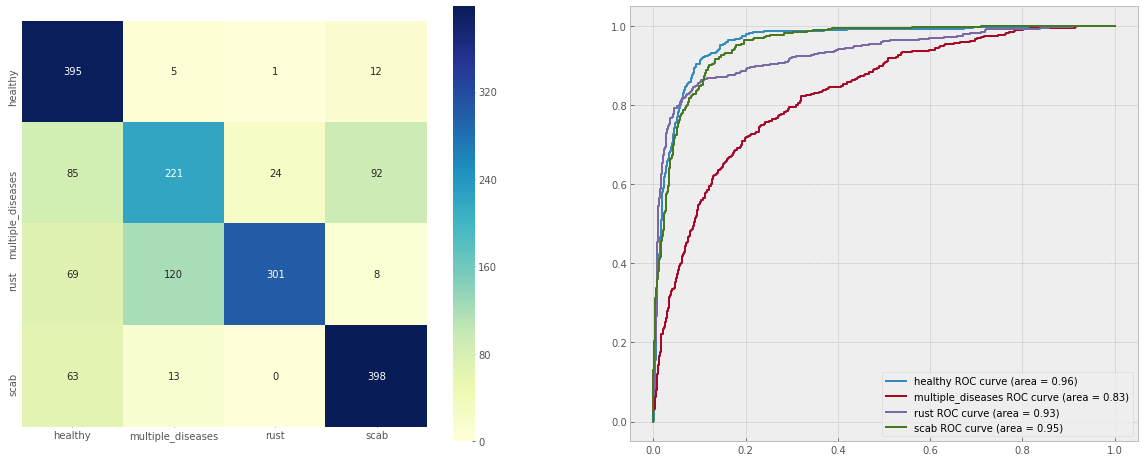

In [11]:
# Compute confusion matrix
conf_mat = confusion_matrix(np.argmax(y_val_running, axis=-1), 
                            np.argmax(y_val_hat_running, axis=-1), 
                            normalize=None)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, label in enumerate(ds_val.label_cols):
    fpr[label], tpr[label], _ = roc_curve(y_val_running[:, i], y_val_hat_running[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])

fig, (ax_cm, ax_roc) = plt.subplots(ncols=2, figsize=(20, 8))

sns.heatmap(conf_mat, fmt='d', annot=True, cmap='YlGnBu', square=True, xticklabels=ds_val.label_cols, yticklabels=ds_val.label_cols, ax=ax_cm)
for i, label in enumerate(ds_val.label_cols):
    ax_roc.plot(fpr[label], tpr[label], label=f'{label} ROC curve (area = {roc_auc[label]:.2f})')
    
plt.legend()

Confusion matrix $C = [c_{ij}]$ where $c_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.

The classifier accurately identifies scab and rust infected leafs as well as healthy ones with a AUC over 0.9. However, the model's performance on leaves with multiple disease is lower with an AUC around 0.83. 

This is actually not surprising, because samples with the class "multiple diseases" are really occurrences with multi-labels: with scab and rust (and potentially other unseen diseases). On these occurrences, the model mainly detects scab signatures and thus output slightly higher probabilities on average and have difficulty to clearly separate samples on the "multiple diseases" class. The model cannot consider multi label occurrences and ends up classifying these as scab or healthy almost half of the time.

In order address this limitation, the problem should be transformed to multi-label one. Each sample of the "multiple diseases" class would be re-classified as occurrences of "scab" and "rust" classes and "multiple diseases" class dropped. Instead of using cross entropy loss with softmax used here, a binary cross entropy loss with sigmoid could be used, as it would consider classes independent and allow for multi labels. During inference, samples with both "scab" and "rust" probabilities over a threshold would be reclassified as "multiple diseases" for the final predictions.

Text(0, 0.5, 'probability')

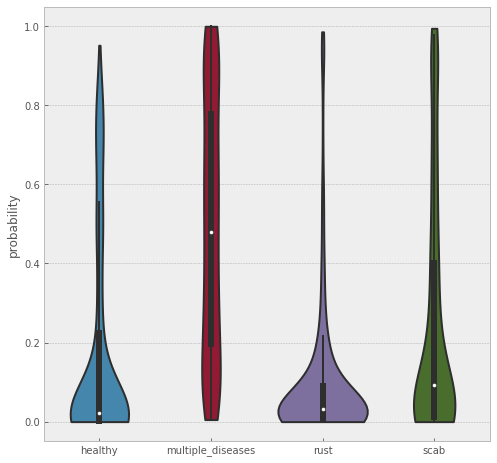

In [12]:
multiple_disease_samples = np.where(y_val_running[:, 1] == 1)
y_val_hat_mutiple_diseases = pd.DataFrame(data=y_val_hat_running[multiple_disease_samples], columns=ds_val.label_cols)

fig, ax = plt.subplots(figsize=(8, 8))
sns.violinplot(data=y_val_hat_mutiple_diseases, cut=0., ax=ax)
ax.set_ylabel('probability')

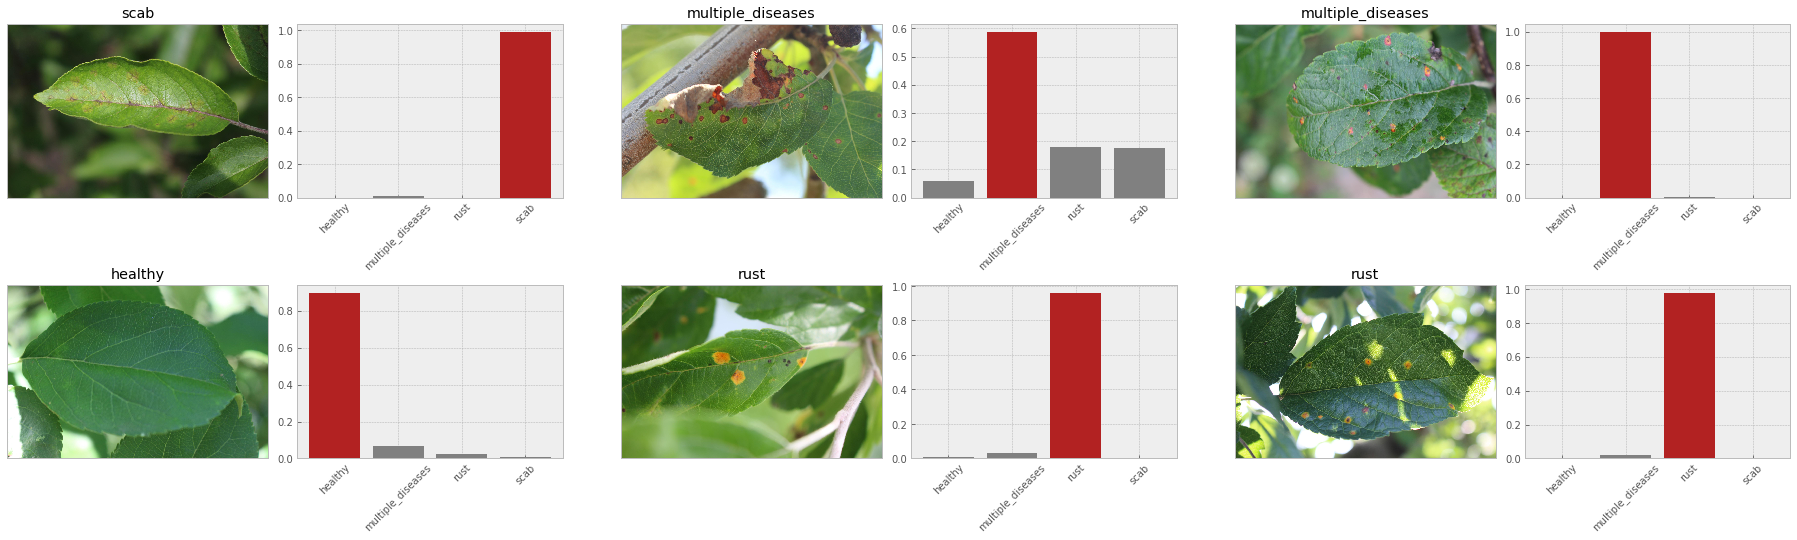

In [13]:
fig = utils.plot_samples_predictions(ds_val, y_val_hat_running)